#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima_model import ARIMA


#### Load the data

In [2]:
df = pd.read_csv('TFP.csv')
df.head()

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179


### 1. Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   isocode  186 non-null    object 
 1   year     186 non-null    int64  
 2   rtfpna   186 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.5+ KB


In [4]:
df.head()

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179


In [5]:
# Ckeck duplicate rows
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows", duplicate_rows_df.shape)

number of duplicate rows (0, 3)


In [6]:
#Check null values
print(df.isnull().sum())

isocode    0
year       0
rtfpna     0
dtype: int64


In [7]:
df['isocode'].value_counts()

USA    62
MEX    62
CAN    62
Name: isocode, dtype: int64

In [8]:
df.loc[df['isocode']=='USA'].describe()

,year,rtfpna
count,62.000000,62.000000
mean,1980.500000,0.803824
std,18.041619,0.116121
min,1950.000000,0.617148
25%,1965.250000,0.739949
50%,1980.500000,0.766047
75%,1995.750000,0.880544
max,2011.000000,1.020392


In [9]:
df.loc[df['isocode']=='MEX'].describe()

,year,rtfpna
count,62.000000,62.000000
mean,1980.500000,1.130132
std,18.041619,0.158209
min,1950.000000,0.798159
25%,1965.250000,1.012231
50%,1980.500000,1.093859
75%,1995.750000,1.299591
max,2011.000000,1.383718


In [10]:
df.loc[df['isocode']=='CAN'].describe()

,year,rtfpna
count,62.000000,62.000000
mean,1980.500000,0.992886
std,18.041619,0.050126
min,1950.000000,0.843335
25%,1965.250000,0.973294
50%,1980.500000,1.004211
75%,1995.750000,1.029513
max,2011.000000,1.066104


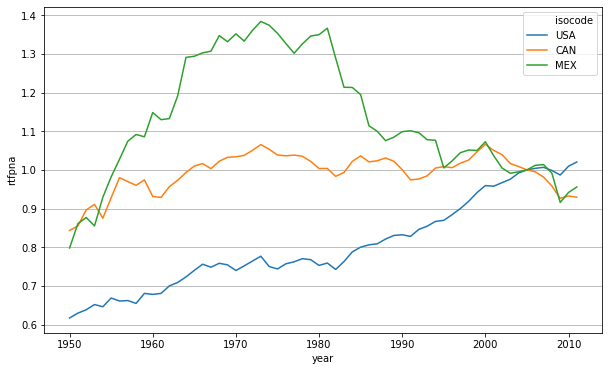

In [11]:
sns.lineplot(df['year'], df['rtfpna'], hue=df['isocode'],ci=None)
plt.grid(axis='y')


### 2. Modelling - Forecasting 10 years of the series

In [12]:
df['year']=pd.to_datetime(df.year, format='%Y')
df.set_index('year', inplace=True)
df

,isocode,rtfpna
year,,
1950-01-01,USA,0.617148
1951-01-01,USA,0.629588
1952-01-01,USA,0.638451
1953-01-01,USA,0.651858
1954-01-01,USA,0.646179
...,...,...
2007-01-01,MEX,1.013673
2008-01-01,MEX,0.991548
2009-01-01,MEX,0.915879


In [13]:
# Check Stationarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.grid(axis='y')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

### USA

Text(0.5, 1.0, 'USA')

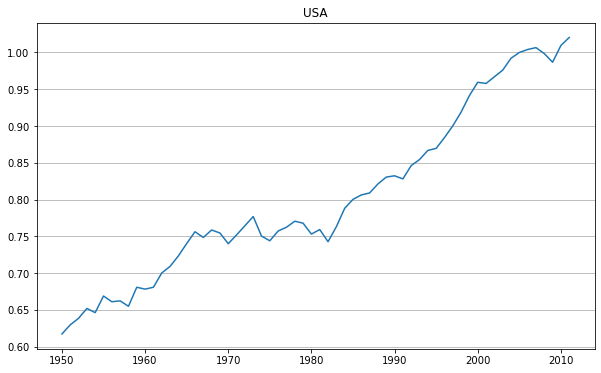

In [14]:
ts_usa = df[df.isocode=='USA']
ts_usa = ts_usa['rtfpna']

plt.plot(ts_usa)
plt.grid(axis='y')
plt.title('USA')

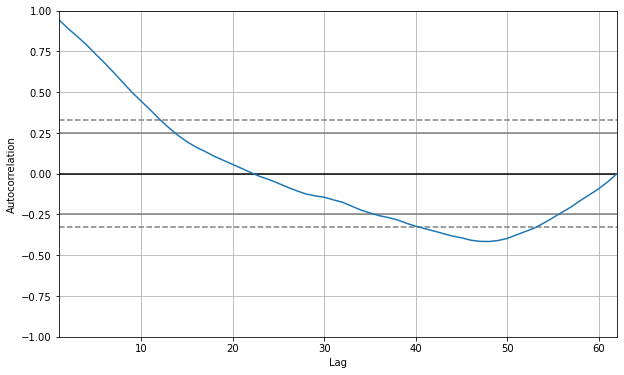

In [15]:
autocorrelation_plot(ts_usa)

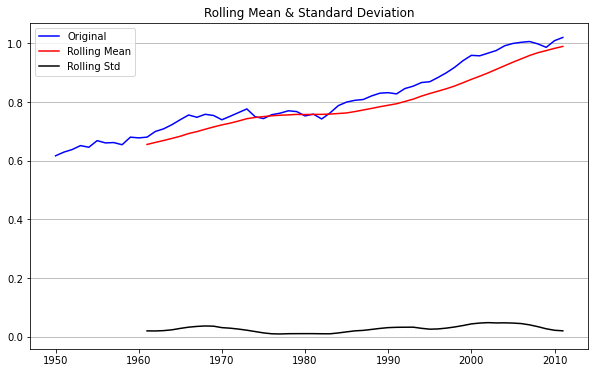

Results of Dickey-Fuller Test:
Test Statistic                  0.223647
p-value                         0.973557
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [16]:
test_stationarity(ts_usa)

Text(0.5, 1.0, 'USA')

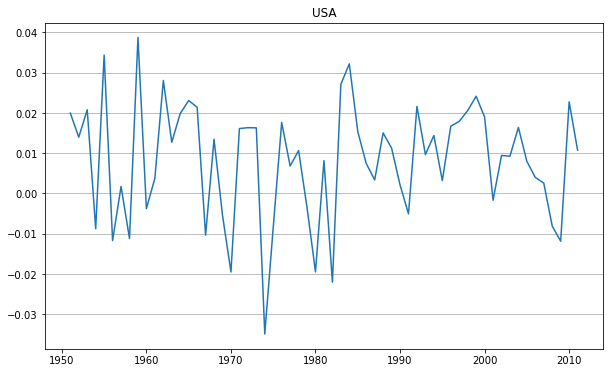

In [17]:
#Making the TS Stationary - Differencing technique

ts_usa_log = np.log(ts_usa)
ts_usa_log_diff_shifting = ts_usa_log - ts_usa_log.shift()
ts_usa_log_diff_shifting.dropna(inplace=True)
plt.plot(ts_usa_log_diff_shifting)
plt.grid(axis='y')
plt.title('USA')

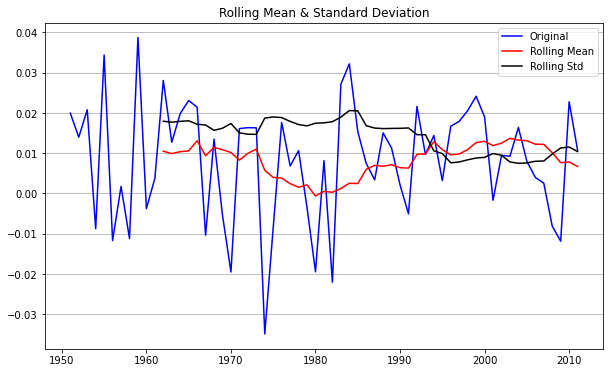

Results of Dickey-Fuller Test:
Test Statistic                -7.874008e+00
p-value                        4.898898e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64


In [18]:
test_stationarity(ts_usa_log_diff_shifting)

#### Autoregressive Integrated Moving Average Model - ARIMA

C:\Users\Cliente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Cliente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 0.0122')

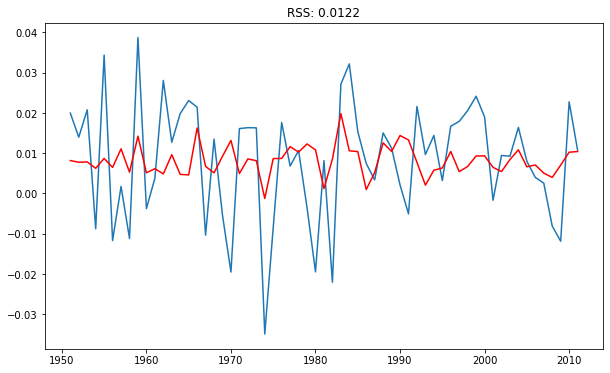

In [19]:
model = ARIMA(ts_usa_log, order=(11, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_usa_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_usa_log_diff_shifting)**2))

In [20]:
#Taking it back to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_usa_log, index=ts_usa_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

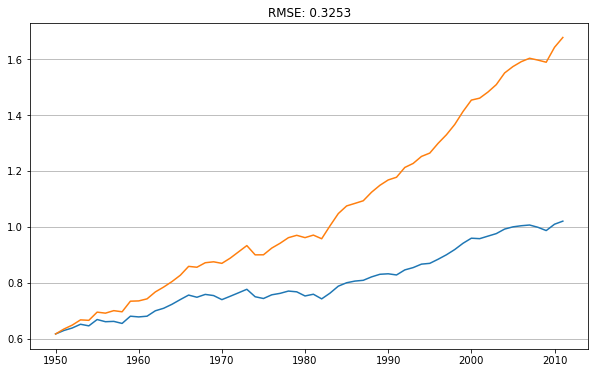

In [21]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_usa)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_usa)**2)/len(ts_usa)))
plt.grid(axis='y')

Text(0.5, 1.0, 'USA rtfpna forecasting')

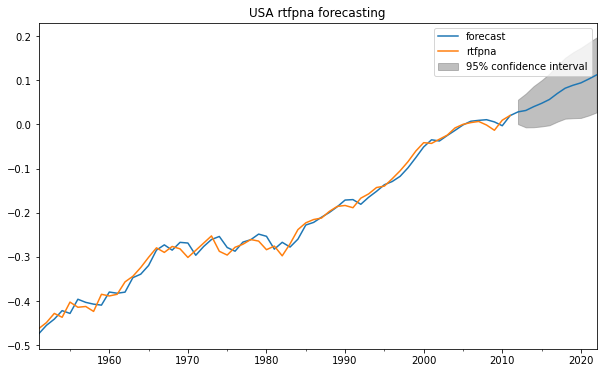

In [22]:
# Forecasting
results_ARIMA.plot_predict(1,72)
x=results_ARIMA.forecast(steps=120)
plt.title('USA rtfpna forecasting')

### CAN

Text(0.5, 1.0, 'CAN')

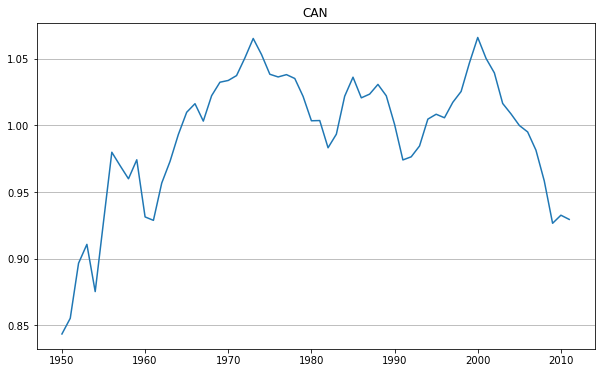

In [23]:
ts_can = df[df.isocode=='CAN']
ts_can = ts_can['rtfpna']

plt.plot(ts_can)
plt.grid(axis='y')
plt.title('CAN')

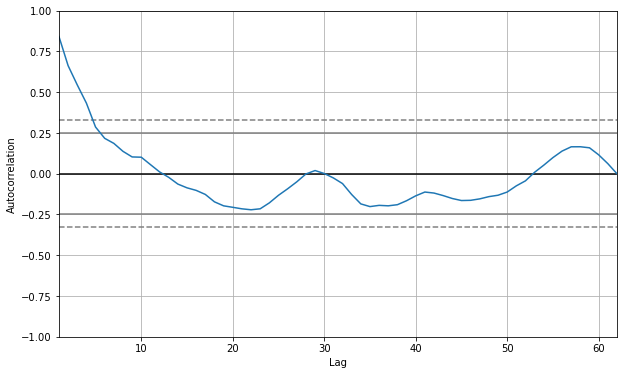

In [24]:
autocorrelation_plot(ts_can)

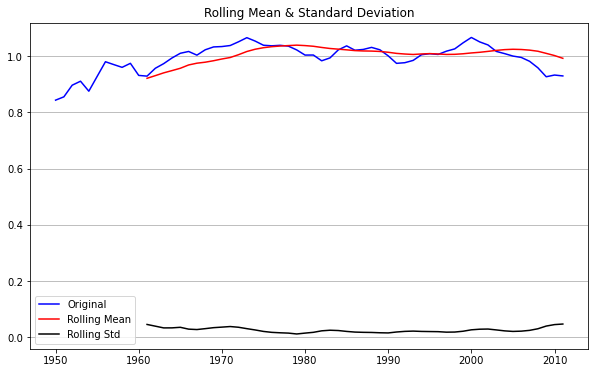

Results of Dickey-Fuller Test:
Test Statistic                 -3.027753
p-value                         0.032383
#Lags Used                      1.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [25]:
test_stationarity(ts_can)

Text(0.5, 1.0, 'CAN')

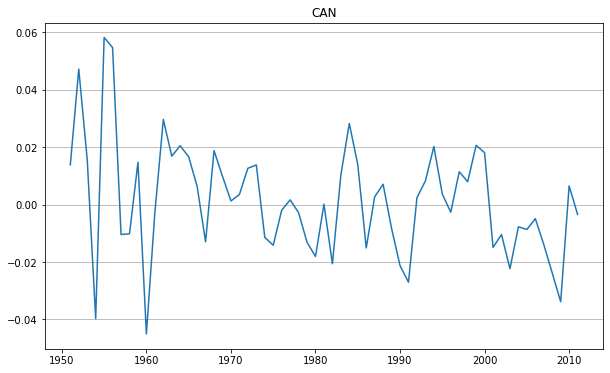

In [26]:
#Making the TS Stationary - Differencing technique

ts_can_log = np.log(ts_can)
ts_can_log_diff_shifting = ts_can_log - ts_can_log.shift()
ts_can_log_diff_shifting.dropna(inplace=True)
plt.plot(ts_can_log_diff_shifting)
plt.grid(axis='y')
plt.title('CAN')

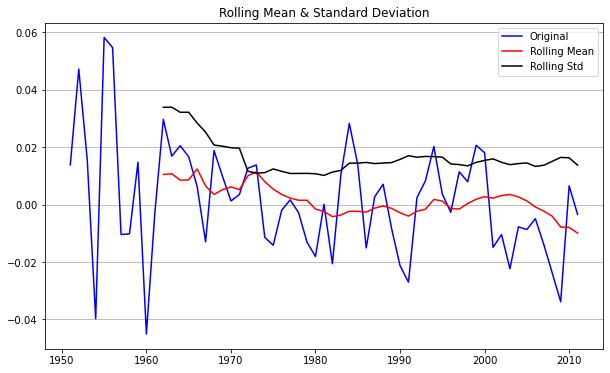

Results of Dickey-Fuller Test:
Test Statistic                -6.178795e+00
p-value                        6.531346e-08
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64


In [27]:
test_stationarity(ts_can_log_diff_shifting)

C:\Users\Cliente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Cliente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Cliente\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Text(0.5, 1.0, 'RSS: 0.0206')

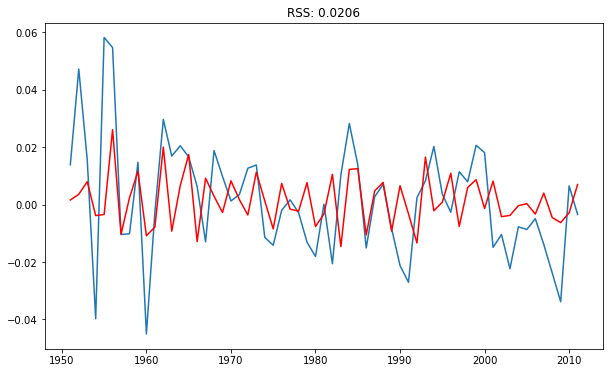

In [28]:
# Autoregressive Integrated Moving Average Model
model = ARIMA(ts_can_log, order=(4, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_can_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_can_log_diff_shifting)**2))

In [29]:
#Taking it back to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_can_log, index=ts_can_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

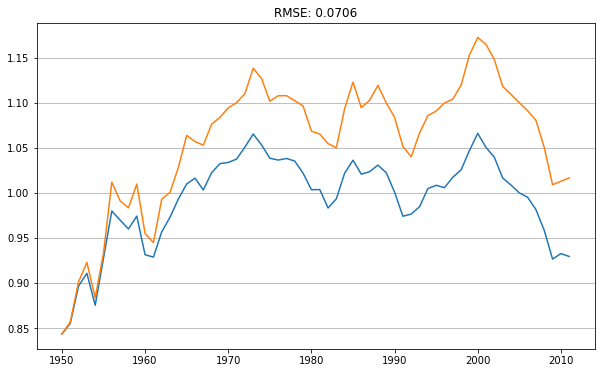

In [30]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_can)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_can)**2)/len(ts_can)))
plt.grid(axis='y')

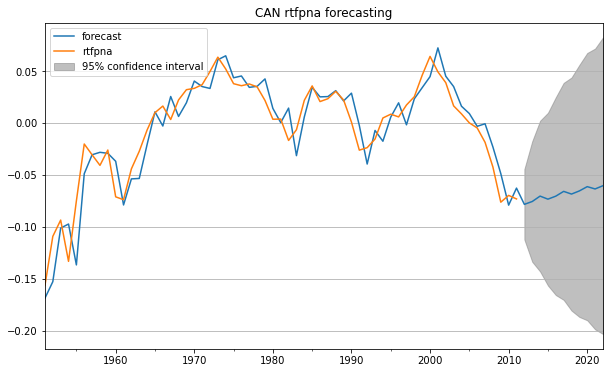

In [31]:
# Forecasting
results_ARIMA.plot_predict(1,72)
x=results_ARIMA.forecast(steps=120)
plt.title('CAN rtfpna forecasting')
plt.grid(axis='y')

### MEX

Text(0.5, 1.0, 'MEX')

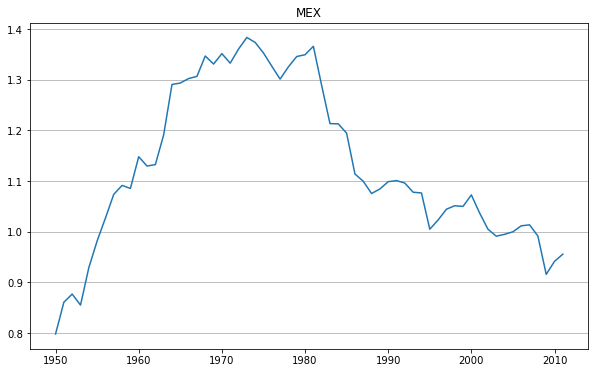

In [32]:
ts_mex = df[df.isocode=='MEX']
ts_mex = ts_mex['rtfpna']

plt.plot(ts_mex)
plt.grid(axis='y')
plt.title('MEX')

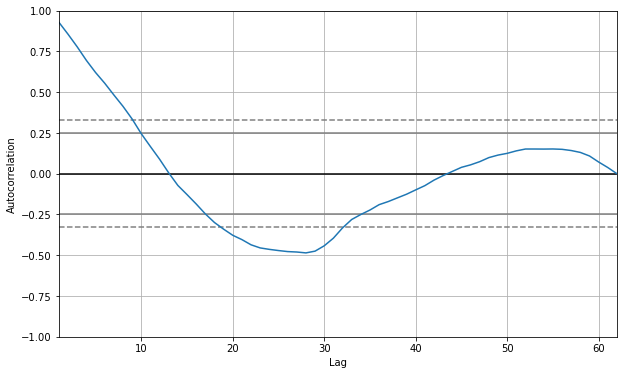

In [33]:
autocorrelation_plot(ts_mex)

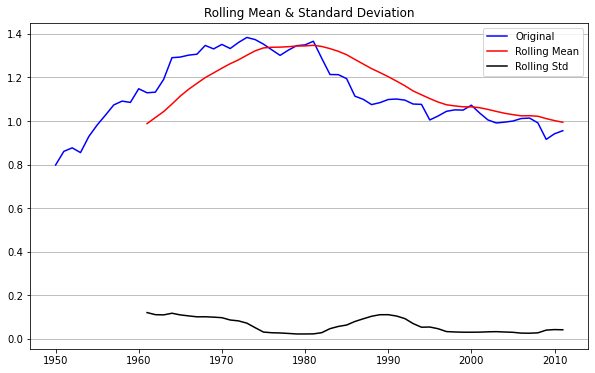

Results of Dickey-Fuller Test:
Test Statistic                 -1.940444
p-value                         0.313281
#Lags Used                      9.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [34]:
test_stationarity(ts_mex)

Text(0.5, 1.0, 'MEX')

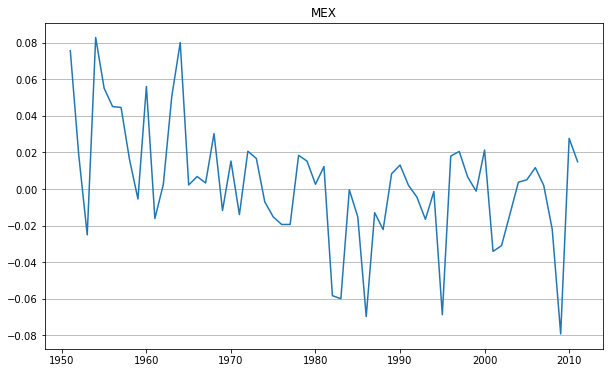

In [35]:
#Making the TS Stationary - Differencing technique

ts_mex_log = np.log(ts_mex)
ts_mex_log_diff_shifting = ts_mex_log - ts_mex_log.shift()
ts_mex_log_diff_shifting.dropna(inplace=True)
plt.plot(ts_mex_log_diff_shifting)
plt.grid(axis='y')
plt.title('MEX')

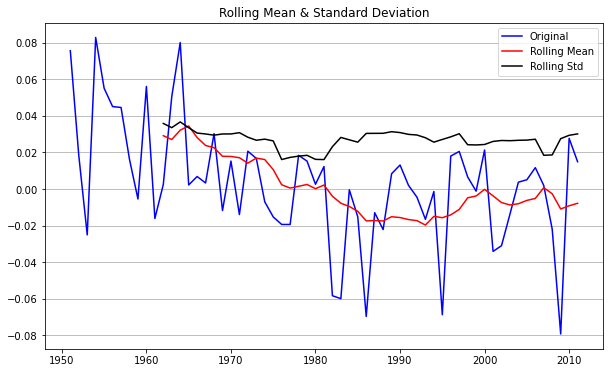

Results of Dickey-Fuller Test:
Test Statistic                -6.156537e+00
p-value                        7.345386e-08
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64


In [36]:
test_stationarity(ts_mex_log_diff_shifting)

C:\Users\Cliente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Cliente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Cliente\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Text(0.5, 1.0, 'RSS: 0.0619')

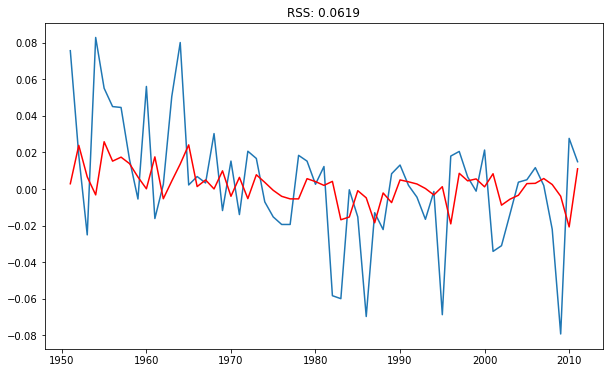

In [37]:
# Autoregressive Integrated Moving Average Model
model = ARIMA(ts_mex_log, order=(4, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_mex_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_mex_log_diff_shifting)**2))

In [38]:
#Taking it back to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_mex_log, index=ts_mex_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

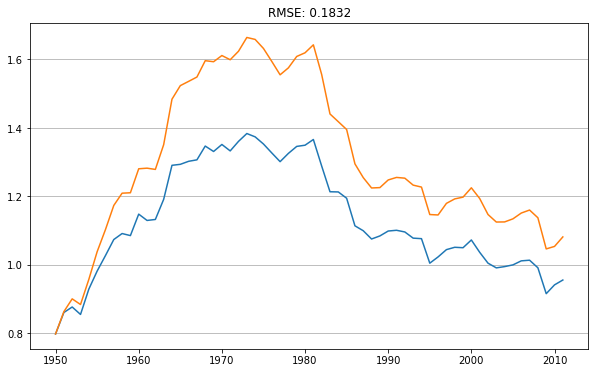

In [39]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_mex)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_mex)**2)/len(ts_mex)))
plt.grid(axis='y')

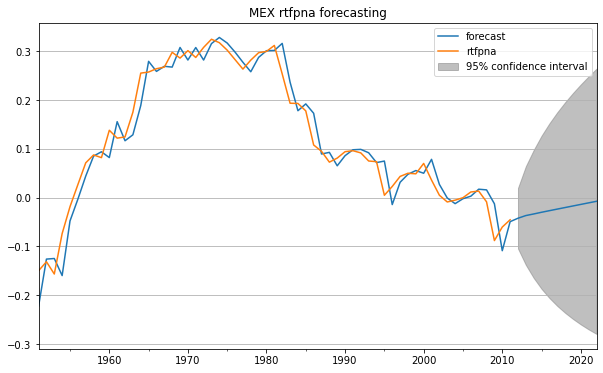

In [40]:
# Forecasting
results_ARIMA.plot_predict(1,72)
x=results_ARIMA.forecast(steps=120)
plt.title('MEX rtfpna forecasting')
plt.grid(axis='y')